# IMPORT LIBRARIES

In [4]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tabulate import tabulate
import nltk
from math import sqrt

# Downloading, merging and preprocessing non financial dataset.

In [5]:
def download_data(ticker, start_date, end_date):
    try:
        df = yf.download(ticker, start=start_date, end=end_date)
        df = df['Close'].rename(ticker)
        return df
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return pd.Series(name=ticker)

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=20*365)).strftime('%Y-%m-%d')

tickers = ['RELIANCE.NS', 'GOLDBEES.NS', 'IOC.NS', 'INR=X']

dataframes = [download_data(ticker, start_date, end_date) for ticker in tickers]

merged_data = pd.concat(dataframes, axis=1).dropna()
merged_data.columns = ['RELIANCE', 'GOLD', 'PETROL', 'CURRENCY']

merged_data.to_csv('merged_data.csv')

if merged_data.isna().any().any():
    print("Warning: NaN values present in the merged data.")
else:
    print("Data downloaded and merged successfully.")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Data downloaded and merged successfully.


In [6]:
data = pd.read_csv('merged_data.csv')
df = data

In [7]:
data

,Date,RELIANCE,GOLD,PETROL,CURRENCY
0,2009-01-02,294.049408,13.370000,35.908333,48.244999
1,2009-01-05,312.210327,13.155500,35.137501,48.229000
2,2009-01-06,313.364685,13.040000,36.229164,48.505001
3,2009-01-07,274.471252,13.215000,35.095833,48.550999
4,2009-01-09,263.613556,13.168900,36.241665,48.467999
...,...,...,...,...,...
3785,2024-05-29,2881.550049,61.200001,165.050003,83.206497
3786,2024-05-30,2849.699951,60.740002,161.949997,83.365601
3787,2024-05-31,2860.800049,61.290001,162.399994,83.320900
3788,2024-06-03,3020.649902,60.590000,175.300003,83.450798


In [8]:
data.dtypes

Date         object
RELIANCE    float64
GOLD        float64
PETROL      float64
CURRENCY    float64
dtype: object

In [9]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year = year, month = month, day = day)
datetime_object = str_to_datetime('2020-01-01')
datetime_object

datetime.datetime(2020, 1, 1, 0, 0)

In [10]:
data['Date'] = data['Date'].apply(str_to_datetime)
data['Date']

0      2009-01-02
1      2009-01-05
2      2009-01-06
3      2009-01-07
4      2009-01-09
          ...    
3785   2024-05-29
3786   2024-05-30
3787   2024-05-31
3788   2024-06-03
3789   2024-06-04
Name: Date, Length: 3790, dtype: datetime64[ns]

In [11]:
data.index = data.pop('Date')
data

,RELIANCE,GOLD,PETROL,CURRENCY
Date,,,,
2009-01-02,294.049408,13.370000,35.908333,48.244999
2009-01-05,312.210327,13.155500,35.137501,48.229000
2009-01-06,313.364685,13.040000,36.229164,48.505001
2009-01-07,274.471252,13.215000,35.095833,48.550999
2009-01-09,263.613556,13.168900,36.241665,48.467999
...,...,...,...,...
2024-05-29,2881.550049,61.200001,165.050003,83.206497
2024-05-30,2849.699951,60.740002,161.949997,83.365601
2024-05-31,2860.800049,61.290001,162.399994,83.320900


In [12]:
data.shape

(3790, 4)

In [13]:
data.describe()

,RELIANCE,GOLD,PETROL,CURRENCY
count,3790.000000,3790.000000,3790.000000,3790.000000
mean,1020.389116,30.786985,74.213659,64.402301
std,787.097660,10.593669,30.613439,11.642436
min,246.309799,0.335500,32.058334,43.900002
25%,422.267433,24.815875,51.912499,54.544250
50%,496.048370,27.570499,66.670834,65.413799
75%,1764.371613,40.820000,90.325003,73.502249
max,3020.649902,62.680000,192.399994,85.194000


In [14]:
print(data.isnull().sum())

RELIANCE    0
GOLD        0
PETROL      0
CURRENCY    0
dtype: int64


In [15]:
data.dropna(inplace=True)

In [16]:
print(data.isnull().sum())

RELIANCE    0
GOLD        0
PETROL      0
CURRENCY    0
dtype: int64


In [17]:
data.shape

(3790, 4)

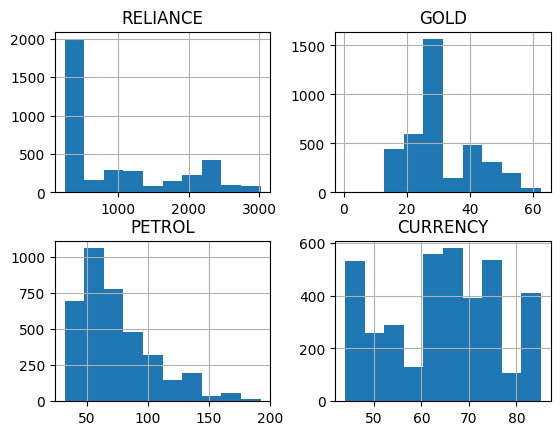

In [18]:
data.hist()
plt.show()

In [19]:
print(data.corr())

          RELIANCE      GOLD    PETROL  CURRENCY
RELIANCE  1.000000  0.908926  0.432863  0.820016
GOLD      0.908926  1.000000  0.373596  0.861466
PETROL    0.432863  0.373596  1.000000  0.515332
CURRENCY  0.820016  0.861466  0.515332  1.000000


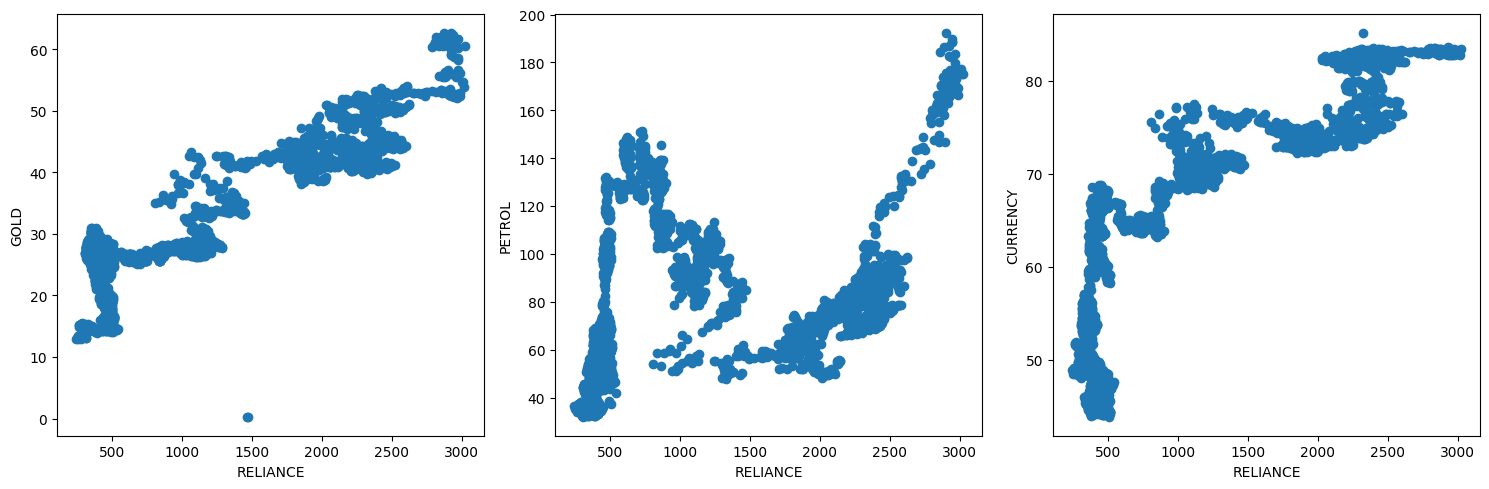

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(['GOLD', 'PETROL', 'CURRENCY']):
    axs[i].scatter(data['RELIANCE'], data[col])
    axs[i].set_xlabel('RELIANCE')
    axs[i].set_ylabel(col)

plt.tight_layout()
plt.show()


# Linear Regression

Actual vs. Predicted Values:
            Actual RELIANCE  Predicted RELIANCE
Date                                           
2015-06-12       406.809479          588.923814
2018-03-13       852.020935          948.103311
2010-02-03       472.687164            3.037826
2016-06-28       437.873932          864.750055
2023-11-10      2314.899902         2422.009898
...                     ...                 ...
2023-05-11      2289.316162         2446.253180
2011-12-28       337.868805          613.283277
2011-01-20       443.382782          201.765578
2015-09-07       380.911011          598.974457
2018-02-23       854.215332          925.887330

[758 rows x 2 columns]

Mean Squared Error (MSE): 110597.11608327352
Root Mean Squared Error (RMSE): 332.5614470789925
Mean Absolute Error (MAE): 273.0074051953198


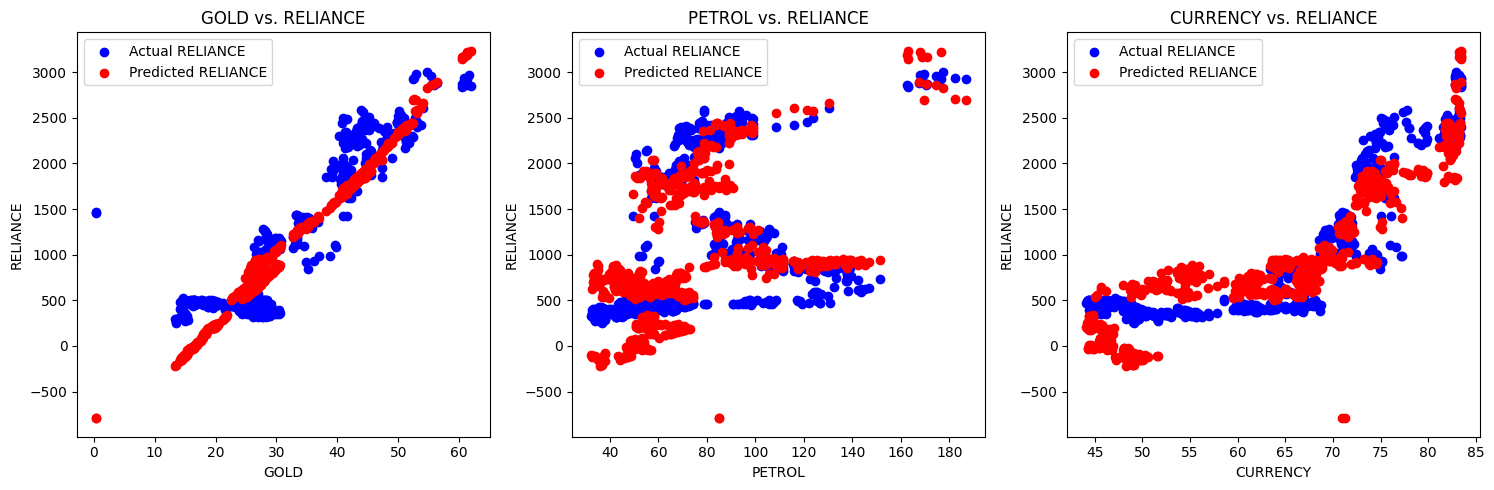

In [21]:
# Assuming data is your dataset
X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['RELIANCE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Display actual and predicted values in a table
results_table = pd.DataFrame({
    'Actual RELIANCE': y_test,
    'Predicted RELIANCE': y_pred
})

print("Actual vs. Predicted Values:")
print(results_table)

# Display evaluation metrics
print(f'\nMean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Plot scatter plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].scatter(X_test['GOLD'], y_test, color='blue', label='Actual RELIANCE')
axes[0].scatter(X_test['GOLD'], y_pred, color='red', label='Predicted RELIANCE')
axes[0].set_xlabel('GOLD')
axes[0].set_ylabel('RELIANCE')
axes[0].set_title('GOLD vs. RELIANCE')
axes[0].legend()

axes[1].scatter(X_test['PETROL'], y_test, color='blue', label='Actual RELIANCE')
axes[1].scatter(X_test['PETROL'], y_pred, color='red', label='Predicted RELIANCE')
axes[1].set_xlabel('PETROL')
axes[1].set_ylabel('RELIANCE')
axes[1].set_title('PETROL vs. RELIANCE')
axes[1].legend()

axes[2].scatter(X_test['CURRENCY'], y_test, color='blue', label='Actual RELIANCE')
axes[2].scatter(X_test['CURRENCY'], y_pred, color='red', label='Predicted RELIANCE')
axes[2].set_xlabel('CURRENCY')
axes[2].set_ylabel('RELIANCE')
axes[2].set_title('CURRENCY vs. RELIANCE')
axes[2].legend()

plt.tight_layout()
plt.show()


In [22]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['RELIANCE']

metrics_dict = {'GOLD': {}, 'PETROL': {}, 'CURRENCY': {}}

for feature in X.columns:
    current_feature = X[[feature]]

    X_train, X_test, y_train, y_test = train_test_split(current_feature, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse, rmse, r2 = calculate_metrics(y_test, y_pred)

    metrics_dict[feature]['MSE'] = mse
    metrics_dict[feature]['RMSE'] = rmse
    metrics_dict[feature]['R-squared'] = r2

for feature, metrics in metrics_dict.items():
    print(f'Feature: {feature}')
    print(f'Mean Squared Error: {metrics["MSE"]}')
    print(f'Root Mean Squared Error: {metrics["RMSE"]}')
    print(f'R-squared: {metrics["R-squared"]}')
    print('-' * 30)


Feature: GOLD
Mean Squared Error: 117242.03841973118
Root Mean Squared Error: 342.4062476353654
R-squared: 0.7936541338425723
------------------------------
Feature: PETROL
Mean Squared Error: 469163.5859709683
Root Mean Squared Error: 684.955170774678
R-squared: 0.1742725747387579
------------------------------
Feature: CURRENCY
Mean Squared Error: 202572.70511826526
Root Mean Squared Error: 450.0807762149648
R-squared: 0.6434722488546658
------------------------------


In [23]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['RELIANCE']

metrics_dict = {'Feature': [], 'MSE': [], 'RMSE': [], 'R-squared': []}

for feature in X.columns:
    current_feature = X[[feature]]

    X_train, X_test, y_train, y_test = train_test_split(current_feature, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse, rmse, r2 = calculate_metrics(y_test, y_pred)

    metrics_dict['Feature'].append(feature)
    metrics_dict['MSE'].append(mse)
    metrics_dict['RMSE'].append(rmse)
    metrics_dict['R-squared'].append(r2)

results_df = pd.DataFrame(metrics_dict)
print(results_df)


    Feature            MSE        RMSE  R-squared
0      GOLD  117242.038420  342.406248   0.793654
1    PETROL  469163.585971  684.955171   0.174273
2  CURRENCY  202572.705118  450.080776   0.643472


# Random Forest

In [24]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['RELIANCE']

metrics_dict_rf = {'Feature': [], 'MSE': [], 'RMSE': [], 'R-squared': []}

for feature in X.columns:
    current_feature = X[[feature]]

    X_train, X_test, y_train, y_test = train_test_split(current_feature, y, test_size=0.2, random_state=42)

    model_rf = RandomForestRegressor(random_state=42)
    model_rf.fit(X_train, y_train)

    y_pred_rf = model_rf.predict(X_test)

    mse_rf, rmse_rf, r2_rf = calculate_metrics(y_test, y_pred_rf)

    metrics_dict_rf['Feature'].append(feature)
    metrics_dict_rf['MSE'].append(mse_rf)
    metrics_dict_rf['RMSE'].append(rmse_rf)
    metrics_dict_rf['R-squared'].append(r2_rf)

results_df_rf = pd.DataFrame(metrics_dict_rf)
print(results_df_rf)


    Feature            MSE        RMSE  R-squared
0      GOLD   69444.548866  263.523336   0.877778
1    PETROL  418240.479126  646.715145   0.263897
2  CURRENCY   54385.615165  233.207237   0.904281


# KNN

In [25]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['RELIANCE']

metrics_dict_knn = {'Feature': [], 'MSE': [], 'RMSE': [], 'R-squared': []}

for feature in X.columns:
    current_feature = X[[feature]]

    X_train, X_test, y_train, y_test = train_test_split(current_feature, y, test_size=0.2, random_state=42)

    model_knn = KNeighborsRegressor(n_neighbors=5)
    model_knn.fit(X_train, y_train)

    y_pred_knn = model_knn.predict(X_test)

    mse_knn, rmse_knn, r2_knn = calculate_metrics(y_test, y_pred_knn)

    metrics_dict_knn['Feature'].append(feature)
    metrics_dict_knn['MSE'].append(mse_knn)
    metrics_dict_knn['RMSE'].append(rmse_knn)
    metrics_dict_knn['R-squared'].append(r2_knn)

results_df_knn = pd.DataFrame(metrics_dict_knn)
print(results_df_knn)


    Feature            MSE        RMSE  R-squared
0      GOLD   57359.682506  239.498815   0.899047
1    PETROL  369800.983566  608.112641   0.349151
2  CURRENCY   43983.205645  209.721734   0.922590


# ANN

In [26]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

# Assuming data is your dataset
X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['RELIANCE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_ann = Sequential()
model_ann.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model_ann.add(Dense(16, activation='relu'))
model_ann.add(Dense(1, activation='linear'))

model_ann.compile(optimizer='adam', loss='mean_squared_error')

model_ann.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

y_pred_ann = model_ann.predict(X_test_scaled).flatten()

mse_ann, rmse_ann, r2_ann = calculate_metrics(y_test, y_pred_ann)

# Create a DataFrame to display actual and predicted prices
results_ann = pd.DataFrame({'Actual Prices': y_test, 'Predicted Prices (ANN)': y_pred_ann})

# Display the DataFrame and metrics
print("Actual and Predicted Prices (ANN):")
print(results_ann.head())

print("\nPerformance Metrics (ANN):")
print(f'Mean Squared Error (ANN): {mse_ann}')
print(f'Root Mean Squared Error (ANN): {rmse_ann}')
print(f'R-squared (ANN): {r2_ann}')


c:\Users\Trupthi K\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Actual and Predicted Prices (ANN):
            Actual Prices  Predicted Prices (ANN)
Date                                             
2015-06-12     406.809479              432.893341
2018-03-13     852.020935              797.708923
2010-02-03     472.687164              466.545715
2016-06-28     437.873932              794.574829
2023-11-10    2314.899902             2668.867920

Performance Metrics (ANN):
Mean Squared Error (ANN): 37318.02754597112
Root Mean Squared Error (ANN): 193.17874506780274
R-squared (ANN): 0.934320310180105


# LSTM

Epoch 1/50


c:\Users\Trupthi K\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6697e-05 - val_loss: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6999e-05 - val_loss: 8.9053e-04
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3175e-05 - val_loss: 6.0356e-04
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9858e-05 - val_loss: 5.5348e-04
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1256e-05 - val_loss: 6.1409e-04
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5296e-05 - val_loss: 5.0510e-04
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.8653e-05 - val_loss: 5.9250e-04
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8025e-05 - val_loss: 5.1600e-04
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8882e-05 - val_loss: 4.6865e-04
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2557e-05 - val_loss: 4.5694e-04
Epoch 12/

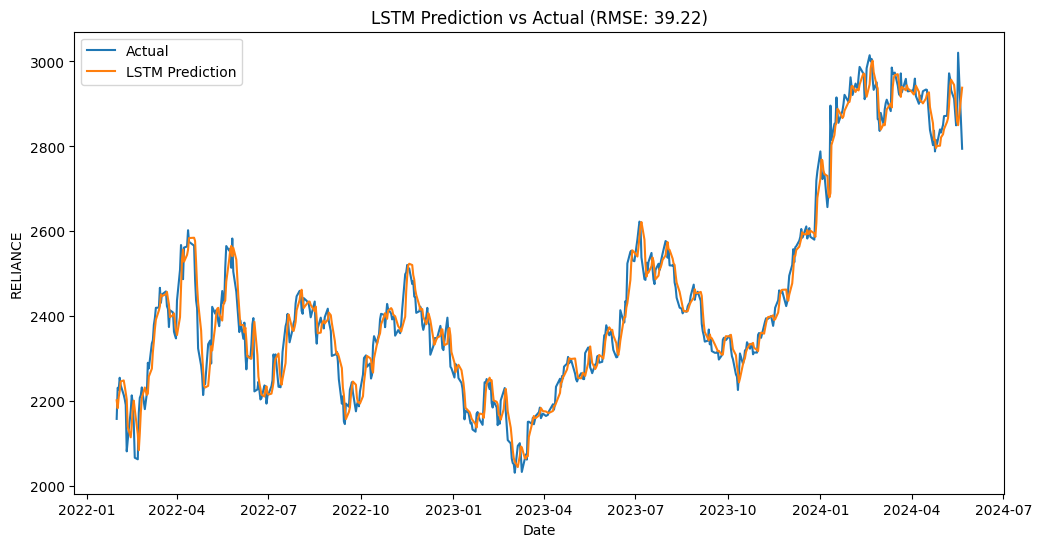

Root Mean Squared Error (RMSE): 39.22
Error Percentage: 1.61%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Forecasted stock prices for the upcoming 7 days:
2024-06-05: 2202.208984375
2024-06-06: 2183.641845703125
2024-06-07: 2209.052978515625
2024-06-08: 2224.08203125
2024-06-09: 2246.54296875
2024-06-10: 2249.11181640625


In [27]:
target_variable = 'RELIANCE'
y = data[target_variable].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y)

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 10

X_seq, y_seq = create_sequences(y_scaled, sequence_length)

train_size = int(len(X_seq) * 0.7)
val_size = int(len(X_seq) * 0.15)
test_size = len(X_seq) - train_size - val_size

X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size+val_size], y_seq[train_size:train_size+val_size]
X_test, y_test = X_seq[train_size+val_size:], y_seq[train_size+val_size:]

model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

y_pred_lstm = model_lstm.predict(X_test)

y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_test_inv = scaler.inverse_transform(y_test)

rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_lstm_inv))

test_dates = data.index[train_size+val_size : train_size+val_size+len(y_test_inv)]

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_inv, label='Actual')
plt.plot(test_dates, y_pred_lstm_inv, label='LSTM Prediction')
plt.title(f'LSTM Prediction vs Actual (RMSE: {rmse_lstm:.2f})')
plt.xlabel('Date')  # Update xlabel to 'Date'
plt.ylabel(target_variable)
plt.legend()
plt.show()

error_percentage = (rmse_lstm / np.mean(y_test_inv)) * 100

print(f'Root Mean Squared Error (RMSE): {rmse_lstm:.2f}')
print(f'Error Percentage: {error_percentage:.2f}%')

forecasted_values_scaled = []
for i in range(7):
    X_new = np.array([X_test[i]])
    forecasted_value_scaled = model_lstm.predict(X_new)[0][0]
    forecasted_values_scaled.append(forecasted_value_scaled)
    X_test = np.concatenate((X_test, X_new), axis=0)

forecasted_values = scaler.inverse_transform(np.array(forecasted_values_scaled).reshape(-1, 1))
forecasted_dates = pd.date_range(data.index[-1], periods=7, freq='D')[1:]

print("Forecasted stock prices for the upcoming 7 days:")
for date, price in zip(forecasted_dates, forecasted_values):
    print(f"{date.strftime('%Y-%m-%d')}: {price[0]}")




# All models together

In [28]:
def calculate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, rmse, mae

X = data[['GOLD', 'PETROL', 'CURRENCY']]
y = data['RELIANCE']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=40)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler_ann = StandardScaler()
X_train_scaled_ann = scaler_ann.fit_transform(X_train)
X_test_scaled_ann = scaler_ann.transform(X_test)
X_val_scaled_ann = scaler_ann.transform(X_val)

scaler_lstm = MinMaxScaler(feature_range=(0, 1))
y_train_scaled_lstm = scaler_lstm.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled_lstm = scaler_lstm.transform(y_test.values.reshape(-1, 1))

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
mse_lr, rmse_lr, mae_lr = calculate_metrics(y_test, y_pred_lr)
error_percentage_lr = (mae_lr / y_test.mean()) * 100

model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
mse_rf, rmse_rf, mae_rf = calculate_metrics(y_test, y_pred_rf)
error_percentage_rf = (mae_rf / y_test.mean()) * 100

metrics_dict_knn = {'Feature': [], 'MSE': [], 'RMSE': [], 'MAE': []}
for feature in X.columns:
    current_feature = X_train[[feature]]
    model_knn = KNeighborsRegressor(n_neighbors=5)
    model_knn.fit(current_feature, y_train)
    current_feature_test = X_test[[feature]]
    y_pred_knn = model_knn.predict(current_feature_test)
    mse_knn, rmse_knn, mae_knn = calculate_metrics(y_test, y_pred_knn)
    metrics_dict_knn['Feature'].append(feature)
    metrics_dict_knn['MSE'].append(mse_knn)
    metrics_dict_knn['RMSE'].append(rmse_knn)
    metrics_dict_knn['MAE'].append(mae_knn)

metrics_df_knn = pd.DataFrame(metrics_dict_knn)
error_percentage_knn = (metrics_df_knn['MAE'].mean() / y_test.mean()) * 100

model_ann = Sequential()
model_ann.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model_ann.add(Dense(16, activation='relu'))
model_ann.add(Dense(1, activation='linear'))
model_ann.compile(optimizer='adam', loss='mean_squared_error')
model_ann.fit(X_train_scaled_ann, y_train, epochs=50, batch_size=32, verbose=0)
y_pred_ann = model_ann.predict(X_test_scaled_ann).flatten()
mse_ann, rmse_ann, mae_ann = calculate_metrics(y_test, y_pred_ann)
error_percentage_ann = (mae_ann / y_test.mean()) * 100

sequence_length_lstm = 10
X_seq_lstm, y_seq_lstm = create_sequences(y_train_scaled_lstm, sequence_length_lstm)

X_seq_val_lstm, y_seq_val_lstm = create_sequences(scaler_lstm.transform(y_val.values.reshape(-1, 1)), sequence_length_lstm)
X_seq_test_lstm, y_seq_test_lstm = create_sequences(y_test_scaled_lstm, sequence_length_lstm)

model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_seq_lstm.shape[1], X_seq_lstm.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_seq_lstm, y_seq_lstm, epochs=50, batch_size=32, validation_data=(X_seq_val_lstm, y_seq_val_lstm), verbose=0)
y_pred_lstm = model_lstm.predict(X_seq_test_lstm)
y_pred_lstm_inv = scaler_lstm.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()
y_test_inv_lstm = scaler_lstm.inverse_transform(y_seq_test_lstm.reshape(-1, 1)).flatten()
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv_lstm, y_pred_lstm_inv))

results_lr = pd.DataFrame({'Actual': y_test, 'Predicted_LR': y_pred_lr})
results_rf = pd.DataFrame({'Actual': y_test, 'Predicted_RF': y_pred_rf})
results_knn = pd.DataFrame({'Actual': y_test, 'Predicted_KNN': y_pred_knn})
results_ann = pd.DataFrame({'Actual': y_test, 'Predicted_ANN': y_pred_ann})
results_lstm = pd.DataFrame({'Actual': y_test_inv_lstm, 'Predicted_LSTM': y_pred_lstm_inv})

error_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'k-Nearest Neighbors', 'Artificial Neural Network', 'LSTM'],
    'MSE': [mse_lr, mse_rf, metrics_df_knn['MSE'].mean(), mse_ann, mean_squared_error(y_test_inv_lstm, y_pred_lstm_inv)],
    'RMSE': [rmse_lr, rmse_rf, metrics_df_knn['RMSE'].mean(), rmse_ann, rmse_lstm],
    'MAE': [mae_lr, mae_rf, metrics_df_knn['MAE'].mean(), mae_ann, mean_absolute_error(y_test_inv_lstm, y_pred_lstm_inv)],
    'Error Percentage': [error_percentage_lr, error_percentage_rf, error_percentage_knn, error_percentage_ann, (mean_absolute_error(y_test_inv_lstm, y_pred_lstm_inv) / y_test_inv_lstm.mean()) * 100]
})

print("Results for Linear Regression:")
print(results_lr.head())
print("\nResults for Random Forest:")
print(results_rf.head())
print("\nResults for k-Nearest Neighbors:")
print(results_knn.head())
print("\nResults for Artificial Neural Network:")
print(results_ann.head())
print("\nResults for LSTM:")
print(results_lstm.head())

print("\nError Table:")
print(error_df)

error_df.to_csv('regression_results.csv', index=False)


c:\Users\Trupthi K\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\Trupthi K\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Results for Linear Regression:
                 Actual  Predicted_LR
Date                                 
2021-09-22  2243.350830   1664.634712
2018-08-02  1068.260620    875.551493
2024-03-07  2957.850098   2820.826148
2021-06-08  2044.075073   1766.139049
2018-01-22   888.274231    910.230836

Results for Random Forest:
                 Actual  Predicted_RF
Date                                 
2021-09-22  2243.350830   2220.344050
2018-08-02  1068.260620    651.716018
2024-03-07  2957.850098   2948.321013
2021-06-08  2044.075073   2117.291101
2018-01-22   888.274231    828.034341

Results for k-Nearest Neighbors:
                 Actual  Predicted_KNN
Date                                  
2021-09-22  2243.350830    1991.796387
2018-08-02  1068.260620     721.367365
2024-03-07  2957.850098    2513.147461
2021-06-08  2044.075073    1756.907202
2018-01-22   888.274231     574.287811

Results for Artificial Neural Network:
                 Actua

# SENTIMENT ANALYSIS

[nltk_data] Downloading package vader_lexicon to C:\Users\Trupthi
[nltk_data]     K\AppData\Roaming\nltk_data...


╒══════════╤═══════════╤════════════════════╕
│ Metric   │     Error │   Error Percentage │
╞══════════╪═══════════╪════════════════════╡
│ MSE      │ 22455.6   │          3505.4    │
├──────────┼───────────┼────────────────────┤
│ RMSE     │   149.852 │            23.3924 │
├──────────┼───────────┼────────────────────┤
│ MAE      │   115.661 │            18.0551 │
╘══════════╧═══════════╧════════════════════╛


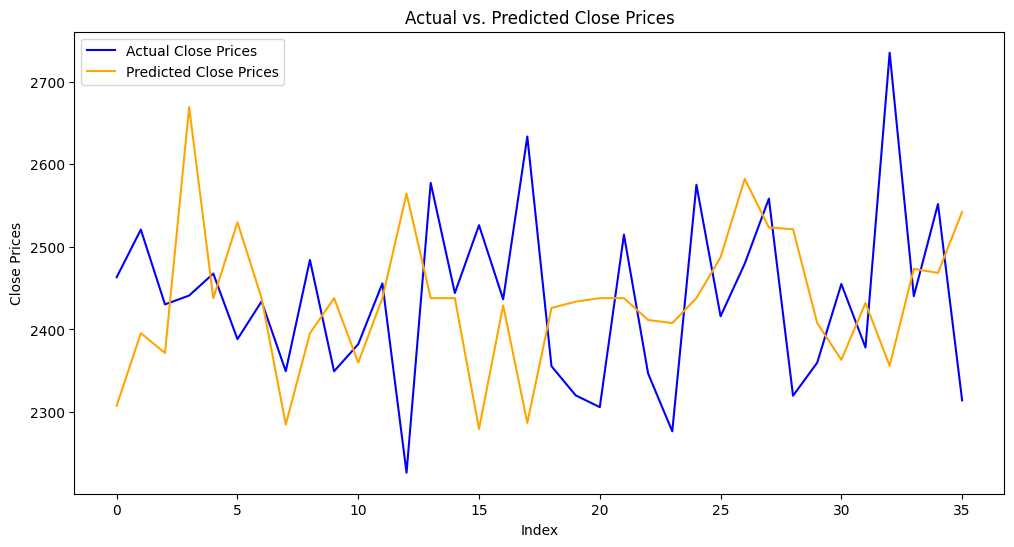

In [29]:
nltk.download('vader_lexicon')

df = pd.read_csv('sentiment.csv')
df['Headline'].fillna('', inplace=True)
df['Content'].fillna('', inplace=True)

sid = SentimentIntensityAnalyzer()
df['Headline_Sentiment'] = df['Headline'].apply(lambda x: sid.polarity_scores(str(x))['compound'])
df['Content_Sentiment'] = df['Content'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

df.to_csv('sentiment_with_scores.csv', index=False)

X = df[['Headline_Sentiment', 'Content_Sentiment']]
y = df['Close']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

test_preds = model.predict(X_test)

y_test = y_test.reset_index(drop=True)
test_preds = pd.Series(test_preds, name='Predicted')

mse_test = mean_squared_error(y_test, test_preds)
rmse_test = sqrt(mse_test)
mae_test = mean_absolute_error(y_test, test_preds)

range_close = y.max() - y.min()
mse_percentage = (mse_test / range_close) * 100
rmse_percentage = (rmse_test / range_close) * 100
mae_percentage = (mae_test / range_close) * 100

table = [['Metric', 'Error', 'Error Percentage'],
         ['MSE', mse_test, mse_percentage],
         ['RMSE', rmse_test, rmse_percentage],
         ['MAE', mae_test, mae_percentage]]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Close Prices', color='blue')
plt.plot(y_test.index, test_preds, label='Predicted Close Prices', color='orange')
plt.xlabel('Index')
plt.ylabel('Close Prices')
plt.title('Actual vs. Predicted Close Prices')
plt.legend()

plt.show()
